# Proximity Score: A New Metric and its Effect on Expected Threat Outcomes

Two types of proximity scores are proposed - one on the player in possession (**pp_proximity_score**) and one on all the passing options the player has (**avg_po_proximity_score**). We calculate them across multiple frames, thus taking into account the velocity of the players. This metric can be thought of as a proxy for pressure but pressure is noted only for the player in possession in general tracking data and proximity score is a measure of distance, thus high score means low pressure. 

Every possession event affects xthreat in some way. So, we track three things from every possession event - the expected threat at the start of the event, the expected threat after the event (e.g. after the player in possession makes a pass to another player or loses the ball etc.), and the best decision the player could have taken during the duration of the possession i.e. the maximum possible expected threat associated with the passing options after taking into account the possibility of pass completion.

From here, we calculate two **xthreat metrics** - **xthreat_increase** that calculates the actual xthreat increase (or decrease for -ve value) by the possession event and **potential_xthreat_reduction** that calculates how much the player in possession underperformed the best possible decision (s)he could have taken.

**Our hypothesis is that higher pressure i.e. lower **proximity score** would cause higher **potential_xthreat_reduction** and also more events with xthtreat_reduction i.e. negative **xthreat_increase**. These scores are appended to the dynamic events dataframe. The possession events are also mapped to different phases in the code below so this is easy to use for researchers, coaches and analysts to understand how a team defends in different phases of play and affects opponent xthreat and vice-versa.** 

We test our hypothesis on the match number 1886347 in the dataset.

In [60]:
# Imports (keep minimal)
import pandas as pd
import numpy as np
from src.extract_dataframe import (
    get_open_data_urls_and_game,
    make_tracking_df,
    make_players_df,
)
from src.utils import (
    time_to_seconds,
    get_first_possession_in_phase,
    get_all_possessions_in_phase,
    add_possession_ids_to_phases_from_events,
    enrich_events_with_linked_events,
    add_xthreat_at_start_for_possessions,
    add_xthreat_at_end_for_possessions,
    add_xthreat_potential_max,
    add_passing_option_proximity,
    add_possession_proximity,
    add_xthreat_deltas,
    add_avg_po_proximity_score
)
pd.set_option('display.max_columns', 100)

# Load the match metadata, events data, phases data and tracking data

In [61]:
# Parameters
match_id = 1886347

# Use helper to get URLs and game object
meta_data_github_url, tracking_data_github_url, dynamic_events_data_github_url, phase_data_github_url, game = get_open_data_urls_and_game(
    match_id=match_id,
    only_alive=False,
)
# # Add velocities on tracking_data (databallpy)
# game.tracking_data.add_velocity(column_ids=game.get_column_ids())

In [62]:
# Build tracking_df from Open Data tracking JSONL
tracking_df = make_tracking_df(tracking_data_github_url, match_id)
tracking_df.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.63,-0.08,51009,False,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347
1,-19.21,-9.18,176224,True,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347
2,-21.83,0.47,51649,True,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347
3,-1.16,-32.47,50983,True,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347
4,-18.88,15.73,735578,True,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347


In [63]:
# Build players_df from match metadata JSON
players_df = make_players_df(meta_data_github_url)
players_df.head()

,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,00:00:00,01:25:21,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,38673,G. May,10,4177,Auckland FC,Center Forward,5121,Center Forward,CF,False,right_to_left,left_to_right
1,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51713,C. Elliott,17,4177,Auckland FC,Full Back,5400,Right Back,RB,False,right_to_left,left_to_right
2,00:00:00,01:16:37,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50951,J. Brimmer,22,4177,Auckland FC,Center Forward,4597,Center Forward,CF,False,right_to_left,left_to_right
3,00:00:00,01:24:58,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50978,C. Timmins,19,1805,Newcastle United Jets FC,Midfield,5098,Left Defensive Midfield,LDM,False,left_to_right,right_to_left
4,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,133498,F. De Vries,15,4177,Auckland FC,Full Back,5400,Left Back,LB,False,right_to_left,left_to_right


In [64]:
# Merge tracking and players to create enriched_tracking_data
enriched_tracking_data = tracking_df.merge(players_df, left_on=['player_id'], right_on=['id'])
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-39.63,-0.08,51009,False,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51009,R. Scott,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-19.21,-9.18,176224,True,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,176224,P. Cancar,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
2,-21.83,0.47,51649,True,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51649,A. Šušnjar,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-1.16,-32.47,50983,True,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50983,D. Ingham,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-18.88,15.73,735578,True,10,2025-12-29,1.0,NaN,None,0.32,0.38,0.13,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,735578,M. Natta,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


In [65]:
# Load dynamic events for the match
de_match = pd.read_csv(dynamic_events_data_github_url)
de_match.head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,xthreat,xpass_completion,passing_option_score,predicted_passing_option,peak_passing_option_frame,passing_option_at_player_possession_start,n_simultaneous_runs,give_and_go,intended_run_behind,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,0.0,1,1,left_to_right,8,player_possession,NaN,NaN,966120,B. Gibson,19,CF,NaN,NaN,NaN,NaN,1805,Newcastle,0.73,0.49,3,center,2,middle_third,False,0.73,0.49,3,center,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,8,player_possession,NaN,NaN,51649,A. Šušnjar,4,LCB,NaN,NaN,NaN,NaN,1805,Newcastle,-22.31,1.22,3,center,1,defensive_third,False,-22.21,2.70,3,center,1,defensive_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False
2,7_0,2,1886347,48,53,NaN,00:03.8,00:04.3,0,3,0.5,1,1,left_to_right,7,passing_option,NaN,NaN,735574,K. Grozos,11,RDM,51649.0,A. Šušnjar,4.0,LCB,1805,Newcastle,-10.47,-2.78,3,center,2,middle_third,False,-11.36,-1.38,3,center,2,middle_third,False,8_1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0006,0.9629,0.9080,True,49.0,True,NaN,NaN,NaN,NaN,NaN,NaN,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
3,7_1,3,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,7,passing_option,NaN,NaN,735578,M. Natta,2,LB,51649.0,A. Šušnjar,4.0,LCB,1805,Newcastle,-20.69,16.66,2,half_space_left,1,defensive_third,False,-20.36,17.69,2,half_space_left,1,defensive_third,False,8_1,48.0,NaN,NaN,NaN

In [66]:
# Read phases of play data
phases_match = pd.read_csv(phase_data_github_url)
phases_match.head()

,index,match_id,frame_start,frame_end,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,team_in_possession_id,attacking_side,team_in_possession_shortname,n_player_possessions_in_phase,team_possession_loss_in_phase,team_possession_lead_to_goal,team_possession_lead_to_shot,team_in_possession_phase_type,team_in_possession_phase_type_id,team_out_of_possession_phase_type,team_out_of_possession_phase_type_id,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,team_in_possession_width_start,team_in_possession_width_end,team_in_possession_length_start,team_in_possession_length_end,team_out_of_possession_width_start,team_out_of_possession_width_end,team_out_of_possession_length_start,team_out_of_possession_length_end
0,0,1886347,28,89,00:01.8,00:07.9,0,1,6.1,1,1,1805,left_to_right,Newcastle,3,False,False,False,create,1,medium_block,9,0.03,-0.36,3,center,2,middle_third,False,-10.70,23.82,1,wide_left,2,middle_third,False,51.72,54.41,41.44,58.03,34.37,32.81,42.01,52.35
1,1,1886347,89,107,00:07.9,00:09.7,0,7,1.8,1,1,1805,left_to_right,Newcastle,1,True,False,False,direct,6,defending_direct,15,-9.87,23.99,1,wide_left,2,middle_third,False,21.73,16.53,2,half_space_left,3,attacking_third,False,54.72,54.54,58.24,62.34,32.97,34.26,51.98,46.99
2,2,1886347,185,232,00:17.5,00:22.2,0,17,4.7,1,2,4177,right_to_left,Auckland FC,2,False,False,False,build_up,0,high_block,10,-22.52,-7.98,3,center,1,defensive_third,False,-20.40,17.83,2,half_space_left,1,defensive_third,False,45.30,50.78,48.51,50.31,31.40,36.38,54.72,51.13
3,3,1886347,232,283,00:22.2,00:27.3,0,22,5.1,1,2,4177,right_to_left,Auckland FC,1,True,False,False,create,1,medium_block,9,-19.24,19.52,2,half_space_left,1,defensive_third,False,29.20,26.16,1,wide_left,3,attacking_third,False,50.81,42.83,50.33,63.89,36.59,38.73,51.22,53.46
4,4,1886347,283,301,00:27.3,00:29.1,0,27,1.8,1,1,1805,left_to_right,Newcastle,1,True,False,False,chaotic,5,chaotic,5,-29.73,-26.19,5,wide_right,1,defensive_third,False,-36.35,-29.24,5,wide_right,1,defensive_third,False,38.61,36.66,53.59,54.36,42.62,40.13,64.54,71.83


# To each phase, add the associated possession events

In [67]:
# --- iterate through all phases in phases_match ---
enriched_phase_rows = []

for _, row in phases_match.iterrows():
    phase_index = int(row["index"])
    frame_start = int(row["frame_start"])
    frame_end = int(row["frame_end"])

    # identify all possession events in THIS phase
    pp_all = get_all_possessions_in_phase(
        de_match,
        phase_frame_start=frame_start,
        phase_frame_end=frame_end,
        phase_index=phase_index,
        enforce_phase_index=False,
        sort=True
    )

    # store them (for debugging or downstream use)
    enriched_phase_rows.append({
        "phase_index": phase_index,
        "frame_start": frame_start,
        "frame_end": frame_end,
        "pp_all": pp_all
    })

# after the loop, build the enriched phases table:
enriched_phases_match = add_possession_ids_to_phases_from_events(
    phases_match=phases_match,
    de_match=de_match,
    enforce_phase_index=False,
    new_col_name="player_possession_event_ids",
    sort_possessions=True
)

# return or print it
enriched_phases_match.head()

,index,match_id,frame_start,frame_end,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,team_in_possession_id,attacking_side,team_in_possession_shortname,n_player_possessions_in_phase,team_possession_loss_in_phase,team_possession_lead_to_goal,team_possession_lead_to_shot,team_in_possession_phase_type,team_in_possession_phase_type_id,team_out_of_possession_phase_type,team_out_of_possession_phase_type_id,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,team_in_possession_width_start,team_in_possession_width_end,team_in_possession_length_start,team_in_possession_length_end,team_out_of_possession_width_start,team_out_of_possession_width_end,team_out_of_possession_length_start,team_out_of_possession_length_end,player_possession_event_ids
0,0,1886347,28,89,00:01.8,00:07.9,0,1,6.1,1,1,1805,left_to_right,Newcastle,3,False,False,False,create,1,medium_block,9,0.03,-0.36,3,center,2,middle_third,False,-10.70,23.82,1,wide_left,2,middle_third,False,51.72,54.41,41.44,58.03,34.37,32.81,42.01,52.35,"8_0,8_1,8_2"
1,1,1886347,89,107,00:07.9,00:09.7,0,7,1.8,1,1,1805,left_to_right,Newcastle,1,True,False,False,direct,6,defending_direct,15,-9.87,23.99,1,wide_left,2,middle_third,False,21.73,16.53,2,half_space_left,3,attacking_third,False,54.72,54.54,58.24,62.34,32.97,34.26,51.98,46.99,8_2
2,2,1886347,185,232,00:17.5,00:22.2,0,17,4.7,1,2,4177,right_to_left,Auckland FC,2,False,False,False,build_up,0,high_block,10,-22.52,-7.98,3,center,1,defensive_third,False,-20.40,17.83,2,half_space_left,1,defensive_third,False,45.30,50.78,48.51,50.31,31.40,36.38,54.72,51.13,8_3
3,3,1886347,232,283,00:22.2,00:27.3,0,22,5.1,1,2,4177,right_to_left,Auckland FC,1,True,False,False,create,1,medium_block,9,-19.24,19.52,2,half_space_left,1,defensive_third,False,29.20,26.16,1,wide_left,3,attacking_third,False,50.81,42.83,50.33,63.89,36.59,38.73,51.22,53.46,"8_4,8_5"
4,4,1886347,283,301,00:27.3,00:29.1,0,27,1.8,1,1,1805,left_to_right,Newcastle,1,True,False,False,chaotic,5,chaotic,5,-29.73,-26.19,5,wide_right,1,defensive_third,False,-36.35,-29.24,5,wide_right,1,defensive_third,False,38.61,36.66,53.59,54.36,42.62,40.13,64.54,71.83,"8_5,8_6"


# To each possession event, add the associated events like passing option, off ball run etc.

In [68]:
# go through the dynamic events and filter all the events that are of type 'player_possession' and name it pp_all.
pp_all = de_match.loc[de_match["event_type"] == "player_possession"].copy()
pp_all = pp_all.sort_values(["frame_start", "frame_end"]).reset_index(drop=True)
print(f"Filtered {len(pp_all)} player_possession event(s).")

Filtered 999 player_possession event(s).


In [69]:
# Enrich the dynamic events with a 'linked_event' column (only for possession rows)
enriched_de_match = enrich_events_with_linked_events(
    de_match=de_match,
    pp_all=pp_all,
    new_col_name="linked_event",
    child_event_types=("passing_option", "off_ball_run", "on_ball_engagement")  # or set to None to include all
)

# Quick inspection: show possession rows with their linked events
enriched_de_match[enriched_de_match["event_type"] == "player_possession"].head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,xpass_completion,passing_option_score,predicted_passing_option,peak_passing_option_frame,passing_option_at_player_possession_start,n_simultaneous_runs,give_and_go,intended_run_behind,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,linked_event
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,0.0,1,1,left_to_right,8,player_possession,NaN,NaN,966120,B. Gibson,19,CF,NaN,NaN,NaN,NaN,1805,Newcastle,0.73,0.49,3,center,2,middle_third,False,0.73,0.49,3,center,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False,
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,8,player_possession,NaN,NaN,51649,A. Šušnjar,4,LCB,NaN,NaN,NaN,NaN,1805,Newcastle,-22.31,1.22,3,center,1,defensive_third,False,-22.21,2.70,3,center,1,defensive_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_0,7_1,9_0"
5,8_2,5,1886347,72,89,NaN,00:06.2,00:07.9,0,6,1.7,1,1,left_to_right,8,player_possession,NaN,NaN,735578,M. Natta,2,LB,NaN,NaN,NaN,NaN,1805,Newcastle,-17.60,20.17,1,wide_left,1,defensive_third,False,-10.75,24.18,1,wide_left,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_2,7_3,7_4,7_5,1_0,9_1,1_1,1_2"
14,8_3,14,1886347,202,229,NaN,00:19.2,00:21.9,0,19,2.7,1,2,right_to_left,8,player_possession,NaN,NaN,33697,N. Pijnaker,4,LCB,NaN,NaN,NaN,NaN,4177,Auckland FC,-27.84,6.40,3,center,1,defensive_third,False,-23.05,13.87,2,half_space_left,1,defensive_third,False

# For each possession event, estimate the xT at the start, xT at the end of the event and the highest expected xT (likelihood weighted)  

In [70]:
# de_match: the dynamic events DataFrame for the match
# Add xthreat_at_start (numeric for PP rows; "" for non-PP rows)
enriched_de_match = add_xthreat_at_start_for_possessions(de_match=enriched_de_match, new_col_name="xthreat_at_start")

# Inspect a few rows
enriched_de_match[enriched_de_match["event_type"] == "player_possession"].head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,passing_option_score,predicted_passing_option,peak_passing_option_frame,passing_option_at_player_possession_start,n_simultaneous_runs,give_and_go,intended_run_behind,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,linked_event,xthreat_at_start
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,0.0,1,1,left_to_right,8,player_possession,NaN,NaN,966120,B. Gibson,19,CF,NaN,NaN,NaN,NaN,1805,Newcastle,0.73,0.49,3,center,2,middle_third,False,0.73,0.49,3,center,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False,,0.0
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,8,player_possession,NaN,NaN,51649,A. Šušnjar,4,LCB,NaN,NaN,NaN,NaN,1805,Newcastle,-22.31,1.22,3,center,1,defensive_third,False,-22.21,2.70,3,center,1,defensive_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_0,7_1,9_0",0.0
5,8_2,5,1886347,72,89,NaN,00:06.2,00:07.9,0,6,1.7,1,1,left_to_right,8,player_possession,NaN,NaN,735578,M. Natta,2,LB,NaN,NaN,NaN,NaN,1805,Newcastle,-17.60,20.17,1,wide_left,1,defensive_third,False,-10.75,24.18,1,wide_left,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_2,7_3,7_4,7_5,1_0,9_1,1_1,1_2",0.0001
14,8_3,14,1886347,202,229,NaN,00:19.2,00:21.9,0,19,2.7,1,2,right_to_left,8,player_possession,NaN,NaN,33697,N. Pijnaker,4,LCB,NaN,NaN,NaN,NaN,4177,Auckland FC,-27.84,6.40,3,center,1,defensive_third,False,-23.05,13.87,2,half_space_left,1,defensive_third,Fa

In [71]:
# de_match: dynamic events DataFrame
enriched_de_match = add_xthreat_at_end_for_possessions(
    de_match=enriched_de_match,
    new_col_name="xthreat_at_end"
)

enriched_de_match[enriched_de_match["event_type"] == "player_possession"].head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,predicted_passing_option,peak_passing_option_frame,passing_option_at_player_possession_start,n_simultaneous_runs,give_and_go,intended_run_behind,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,linked_event,xthreat_at_start,xthreat_at_end
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,0.0,1,1,left_to_right,8,player_possession,NaN,NaN,966120,B. Gibson,19,CF,NaN,NaN,NaN,NaN,1805,Newcastle,0.73,0.49,3,center,2,middle_third,False,0.73,0.49,3,center,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False,,0.0,0.0
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,8,player_possession,NaN,NaN,51649,A. Šušnjar,4,LCB,NaN,NaN,NaN,NaN,1805,Newcastle,-22.31,1.22,3,center,1,defensive_third,False,-22.21,2.70,3,center,1,defensive_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_0,7_1,9_0",0.0,0.0001
5,8_2,5,1886347,72,89,NaN,00:06.2,00:07.9,0,6,1.7,1,1,left_to_right,8,player_possession,NaN,NaN,735578,M. Natta,2,LB,NaN,NaN,NaN,NaN,1805,Newcastle,-17.60,20.17,1,wide_left,1,defensive_third,False,-10.75,24.18,1,wide_left,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_2,7_3,7_4,7_5,1_0,9_1,1_1,1_2",0.0001,0.0
14,8_3,14,1886347,202,229,NaN,00:19.2,00:21.9,0,19,2.7,1,2,right_to_left,8,player_possession,NaN,NaN,33697,N. Pijnaker,4,LCB,NaN,NaN,NaN,NaN,4177,Auckland FC,-27.84,6.40,3,center,1,defensive_third,False,-23.05,13.87,2,half_space_left,1,defensive_third,False

In [72]:
# enriched_de_match: current events DataFrame (already enriched with `linked_event`,
#                    and with xthreat/xpass_completion populated on passing_option rows)

enriched_de_match = add_xthreat_potential_max(
    enriched_de_match=enriched_de_match,
    linked_col="linked_event",              
    new_col_name="xthreat_potential_max"
)

# Sanity check: PP rows should have float values; other rows should be empty ""
enriched_de_match[enriched_de_match["event_type"] == "player_possession"].head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,peak_passing_option_frame,passing_option_at_player_possession_start,n_simultaneous_runs,give_and_go,intended_run_behind,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,linked_event,xthreat_at_start,xthreat_at_end,xthreat_potential_max
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,0.0,1,1,left_to_right,8,player_possession,NaN,NaN,966120,B. Gibson,19,CF,NaN,NaN,NaN,NaN,1805,Newcastle,0.73,0.49,3,center,2,middle_third,False,0.73,0.49,3,center,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False,,0.0,0.0,0.0
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,8,player_possession,NaN,NaN,51649,A. Šušnjar,4,LCB,NaN,NaN,NaN,NaN,1805,Newcastle,-22.31,1.22,3,center,1,defensive_third,False,-22.21,2.70,3,center,1,defensive_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_0,7_1,9_0",0.0,0.0001,0.000578
5,8_2,5,1886347,72,89,NaN,00:06.2,00:07.9,0,6,1.7,1,1,left_to_right,8,player_possession,NaN,NaN,735578,M. Natta,2,LB,NaN,NaN,NaN,NaN,1805,Newcastle,-17.60,20.17,1,wide_left,1,defensive_third,False,-10.75,24.18,1,wide_left,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_2,7_3,7_4,7_5,1_0,9_1,1_1,1_2",0.0001,0.0,0.005807
14,8_3,14,1886347,202,229,NaN,00:19.2,00:21.9,0,19,2.7,1,2,right_to_left,8,player_possession,NaN,NaN,33697,N. Pijnaker,4,LCB,NaN,NaN,NaN,NaN,4177,Auckland FC,-27.84,6.40,3,center,1,defensive_third,False,-23.05,13.87,2,half_space_left,1,defensive_thir

# Estimate the xT increase due to the possession event and how much the original final xT and the maximum expected xT differ

In [73]:
# Starting from events DF after already adding:
#  - xthreat_at_start
#  - xthreat_at_end
#  - xthreat_potential_max

enriched_de_match = add_xthreat_deltas(
    enriched_de_match=enriched_de_match,
    col_start="xthreat_at_start",
    col_end="xthreat_at_end",
    col_pmax="xthreat_potential_max",
    out_delta="xthreat_increase",
    out_pot_red="potential_xthreat_reduction"
)

# Inspect a few player possession rows:
enriched_de_match[enriched_de_match["event_type"] == "player_possession"].head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,n_simultaneous_runs,give_and_go,intended_run_behind,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,linked_event,xthreat_at_start,xthreat_at_end,xthreat_potential_max,xthreat_increase,potential_xthreat_reduction
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,0.0,1,1,left_to_right,8,player_possession,NaN,NaN,966120,B. Gibson,19,CF,NaN,NaN,NaN,NaN,1805,Newcastle,0.73,0.49,3,center,2,middle_third,False,0.73,0.49,3,center,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False,,0.0,0.0,0.0,0.0,0.0
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,8,player_possession,NaN,NaN,51649,A. Šušnjar,4,LCB,NaN,NaN,NaN,NaN,1805,Newcastle,-22.31,1.22,3,center,1,defensive_third,False,-22.21,2.70,3,center,1,defensive_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_0,7_1,9_0",0.0,0.0001,0.000578,0.0001,0.000478
5,8_2,5,1886347,72,89,NaN,00:06.2,00:07.9,0,6,1.7,1,1,left_to_right,8,player_possession,NaN,NaN,735578,M. Natta,2,LB,NaN,NaN,NaN,NaN,1805,Newcastle,-17.60,20.17,1,wide_left,1,defensive_third,False,-10.75,24.18,1,wide_left,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_2,7_3,7_4,7_5,1_0,9_1,1_1,1_2",0.0001,0.0,0.005807,-0.0001,0.005807
14,8_3,14,1886347,202,229,NaN,00:19.2,00:21.9,0,19,2.7,1,2,right_to_left,8,player_possession,NaN,NaN,33697,N. Pijnaker,4,LCB,NaN,NaN,NaN,NaN,4177,Auckland FC,-27.84,6.40,3,center,1,defensive_third,False,-23.05,13.87,2,half_space_left,1,defensive_third,Fals

# Estimate proximity scores of defenders who are nearest to the passing option and then the defender nearest to the player in possession

In [74]:
# enriched_de_match: current events DF after previous enrichments
# enriched_tracking_data: per-frame tracking (columns: frame, player_id, x, y, is_detected, [ball_status])

enriched_de_match = add_passing_option_proximity(
    enriched_de_match=enriched_de_match,
    enriched_tracking_data=enriched_tracking_data,
    new_col_name="po_proximity_score",   
    team_map=None,                       # or pass a DataFrame ['player_id','team_id'] to control mapping
    require_ball_in_play=False           # set True to explicitly ignore dead-ball frames
)

# Quick sanity check
enriched_de_match[enriched_de_match["event_type"] == "passing_option"].head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,give_and_go,intended_run_behind,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,linked_event,xthreat_at_start,xthreat_at_end,xthreat_potential_max,xthreat_increase,potential_xthreat_reduction,po_proximity_score
2,7_0,2,1886347,48,53,NaN,00:03.8,00:04.3,0,3,0.5,1,1,left_to_right,7,passing_option,NaN,NaN,735574,K. Grozos,11,RDM,51649.0,A. Šušnjar,4.0,LCB,1805,Newcastle,-10.47,-2.78,3,center,2,middle_third,False,-11.36,-1.38,3,center,2,middle_third,False,8_1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False,,,,,,,0.842568
3,7_1,3,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,7,passing_option,NaN,NaN,735578,M. Natta,2,LB,51649.0,A. Šušnjar,4.0,LCB,1805,Newcastle,-20.69,16.66,2,half_space_left,1,defensive_third,False,-20.36,17.69,2,half_space_left,1,defensive_third,False,8_1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False,,,,,,,15.118051
6,7_2,6,1886347,72,82,NaN,00:06.2,00:07.2,0,6,1.0,1,1,left_to_right,7,passing_option,NaN,NaN,50978,C. Timmins,9,LDM,735578.0,M. Natta,2.0,LB,1805,Newcastle,-4.66,11.04,2,half_space_left,2,middle_third,False,-6.39,14.27,2,half_space_left,2,middle_third,False,8_2,72.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False,,,,,,,7.542031
7,7_3,7,1886347,72,89,NaN,00:06.2,00:07.9,0,6,1.7,1,1,left_to_right,7,passing_option,NaN,NaN,795507,L. Bayliss,15,AM,735578.0,M. Natta,2.0,LB,1805,Newcastle,14.93,10.13,2,half_space_left,2,middle_third,False,11.67,16.14,2,half_space_left,2,middle_third,False,8_2,72.0,NaN,NaN,NaN,1_1,2.0,coming_short,...,NaN,

In [75]:
# enriched_de_match: enriched events DataFrame (with player_possession & passing_option rows, etc.)
# enriched_tracking_data: per-frame tracking with columns: frame, player_id, x, y, is_detected, [ball_status]

enriched_de_match = add_possession_proximity(
    enriched_de_match=enriched_de_match,
    enriched_tracking_data=enriched_tracking_data,
    new_col_name="pp_proximity_score",
    team_map=None,                 
    require_ball_in_play=False     # set True to ignore frames where ball_status == 'dead'
)

# Inspect a few player possession rows:
enriched_de_match[enriched_de_match["event_type"] == "player_possession"].head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,intended_run_behind,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,linked_event,xthreat_at_start,xthreat_at_end,xthreat_potential_max,xthreat_increase,potential_xthreat_reduction,po_proximity_score,pp_proximity_score
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,0.0,1,1,left_to_right,8,player_possession,NaN,NaN,966120,B. Gibson,19,CF,NaN,NaN,NaN,NaN,1805,Newcastle,0.73,0.49,3,center,2,middle_third,False,0.73,0.49,3,center,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False,,0.0,0.0,0.0,0.0,0.0,,8.657043
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,8,player_possession,NaN,NaN,51649,A. Šušnjar,4,LCB,NaN,NaN,NaN,NaN,1805,Newcastle,-22.31,1.22,3,center,1,defensive_third,False,-22.21,2.70,3,center,1,defensive_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_0,7_1,9_0",0.0,0.0001,0.000578,0.0001,0.000478,,11.245402
5,8_2,5,1886347,72,89,NaN,00:06.2,00:07.9,0,6,1.7,1,1,left_to_right,8,player_possession,NaN,NaN,735578,M. Natta,2,LB,NaN,NaN,NaN,NaN,1805,Newcastle,-17.60,20.17,1,wide_left,1,defensive_third,False,-10.75,24.18,1,wide_left,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_2,7_3,7_4,7_5,1_0,9_1,1_1,1_2",0.0001,0.0,0.005807,-0.0001,0.005807,,4.748693
14,8_3,14,1886347,202,229,NaN,00:19.2,00:21.9,0,19,2.7,1,2,right_to_left,8,player_possession,NaN,NaN,33697,N. Pijnaker,4,LCB,NaN,NaN,NaN,NaN,4177,Auckland FC,-27.84,6.40,3,center,1,defensive_third,False,-23.05,13.87,2,half_space_left,1,defensi

In [76]:
# enriched_de_match: current events DF (already has `linked_event`
# and `po_proximity_score` computed for passing_option rows)

enriched_de_match = add_avg_po_proximity_score(
    enriched_de_match=enriched_de_match,
    linked_col="linked_event",             
    po_score_col="po_proximity_score",
    new_col_name="avg_po_proximity_score"
)

# Quick sanity check: PP rows should have a float or NaN; others should be empty
enriched_de_match[enriched_de_match["event_type"] == "player_possession"].head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,...,push_defensive_line,break_defensive_line,passing_option_at_start,n_simultaneous_passing_options,passing_option_at_pass_moment,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,pressing_chain,pressing_chain_length,pressing_chain_end_type_id,pressing_chain_end_type,pressing_chain_index,index_in_pressing_chain,simultaneous_defensive_engagement_same_target,simultaneous_defensive_engagement_same_target_rank,affected_line_breaking_passing_option_id,affected_line_break_id,affected_line_break,affected_line_breaking_passing_option_attempted,affected_line_breaking_passing_option_xthreat,affected_line_breaking_passing_option_dangerous,affected_line_breaking_passing_option_run_subtype_id,affected_line_breaking_passing_option_run_subtype,possession_danger,beaten_by_possession,beaten_by_movement,stop_possession_danger,reduce_possession_danger,force_backward,xloss_player_possession_start,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,linked_event,xthreat_at_start,xthreat_at_end,xthreat_potential_max,xthreat_increase,potential_xthreat_reduction,po_proximity_score,pp_proximity_score,avg_po_proximity_score
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,0.0,1,1,left_to_right,8,player_possession,NaN,NaN,966120,B. Gibson,19,CF,NaN,NaN,NaN,NaN,1805,Newcastle,0.73,0.49,3,center,2,middle_third,False,0.73,0.49,3,center,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False,,0.0,0.0,0.0,0.0,0.0,,8.657043,NaN
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,1.0,1,1,left_to_right,8,player_possession,NaN,NaN,51649,A. Šušnjar,4,LCB,NaN,NaN,NaN,NaN,1805,Newcastle,-22.31,1.22,3,center,1,defensive_third,False,-22.21,2.70,3,center,1,defensive_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_0,7_1,9_0",0.0,0.0001,0.000578,0.0001,0.000478,,11.245402,7.980309
5,8_2,5,1886347,72,89,NaN,00:06.2,00:07.9,0,6,1.7,1,1,left_to_right,8,player_possession,NaN,NaN,735578,M. Natta,2,LB,NaN,NaN,NaN,NaN,1805,Newcastle,-17.60,20.17,1,wide_left,1,defensive_third,False,-10.75,24.18,1,wide_left,2,middle_third,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,"7_2,7_3,7_4,7_5,1_0,9_1,1_1,1_2",0.0001,0.0,0.005807,-0.0001,0.005807,,4.748693,6.112504
14,8_3,14,1886347,202,229,NaN,00:19.2,00:21.9,0,19,2.7,1,2,right_to_left,8,player_possession,NaN,NaN,33697,N. Pijnaker,4,LCB,NaN,NaN,NaN,NaN,4177,Auckland FC,-27.84,6.40,3,center,1,defensive_third,False,-23.05,13.87,2,half_space_l

# Plot the underperforming of the maximum expected xT vs the proximity score by opponent against the player in possession and against the passing options

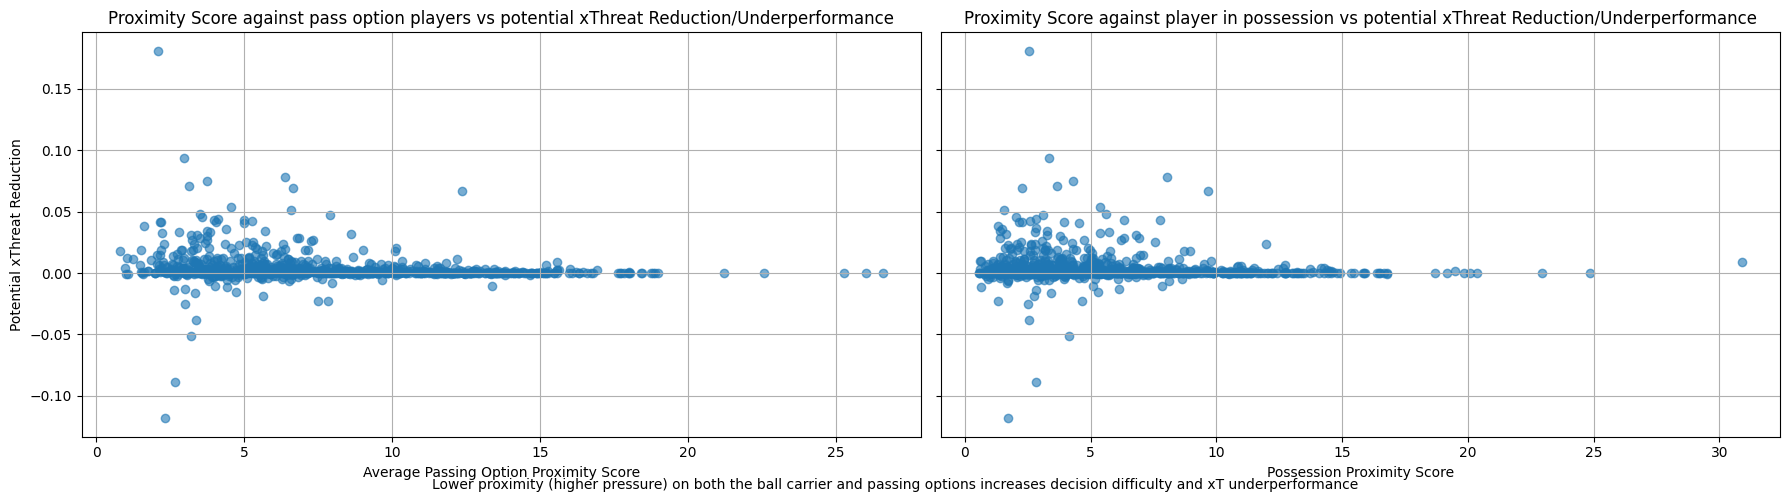

In [77]:
# Side-by-side subplots: avg_po vs reduction, and pp vs reduction
import matplotlib.pyplot as plt
pp_rows = enriched_de_match[enriched_de_match["event_type"] == "player_possession"]

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

# Left: Average Passing Option Proximity vs Potential xThreat Reduction
axes[0].scatter(
    pp_rows["avg_po_proximity_score"],
    pp_rows["potential_xthreat_reduction"],
    alpha=0.6,
)
axes[0].set_xlabel("Average Passing Option Proximity Score")
axes[0].set_ylabel("Potential xThreat Reduction")
axes[0].set_title("Proximity Score against pass option players vs potential xThreat Reduction/Underperformance")
axes[0].grid(True)

# Right: Possession Proximity vs Potential xThreat Reduction
axes[1].scatter(
    pp_rows["pp_proximity_score"],
    pp_rows["potential_xthreat_reduction"],
    alpha=0.6,
)
axes[1].set_xlabel("Possession Proximity Score")
axes[1].set_title("Proximity Score against player in possession vs potential xThreat Reduction/Underperformance")
axes[1].grid(True)

plt.tight_layout()
fig.text(
    0.5, 0.02,
    "Lower proximity (higher pressure) on both the ball carrier and passing options increases decision difficulty and xT underperformance",
    ha="center", va="center", fontsize=10
)
# plt.title("Lower proximity (equivalent to higher pressure) on both the player in posession and the passing options cause higher decision problem and xT underperformance")
plt.show()


# Plot the xT outcome from the possession event vs the proximity score by opponent against the player in possession and against the passing options

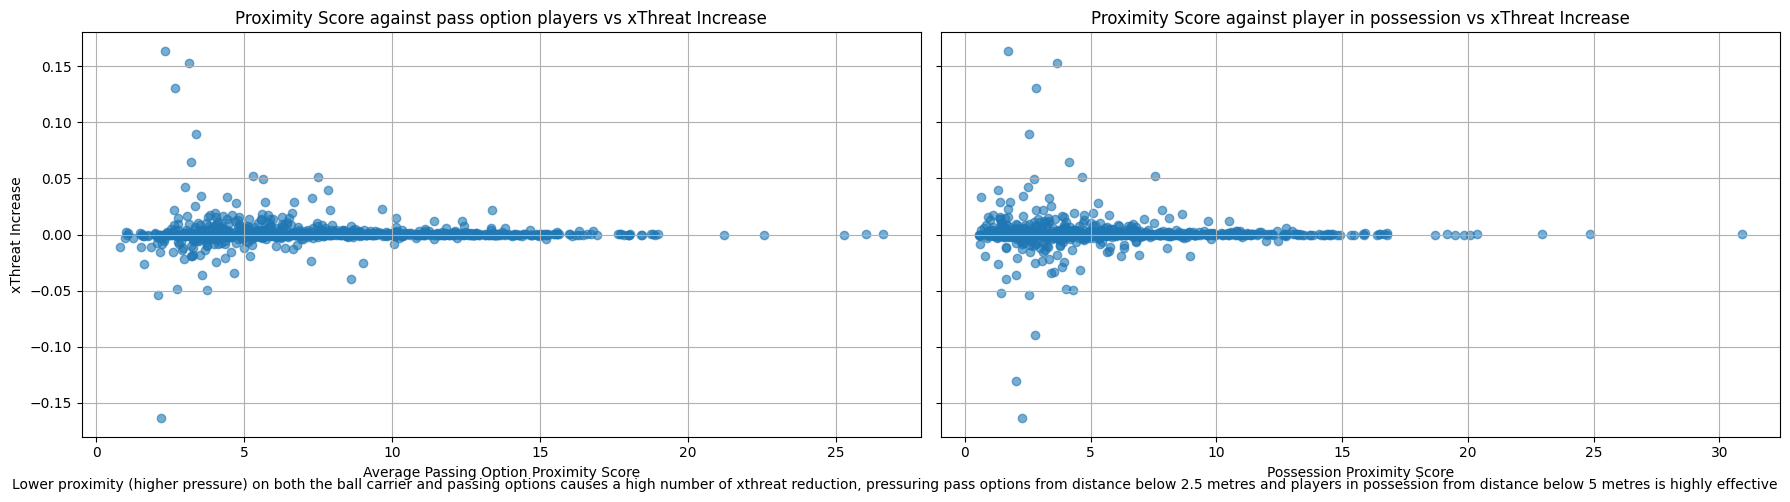

In [78]:
# Side-by-side subplots: avg_po vs xThreat Increase, and pp vs xThreat Increase
import matplotlib.pyplot as plt
pp_rows = enriched_de_match[enriched_de_match["event_type"] == "player_possession"]

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

# Left: Average Passing Option Proximity vs xThreat Increase
axes[0].scatter(
    pp_rows["avg_po_proximity_score"],
    pp_rows["xthreat_increase"],
    alpha=0.6,
)
axes[0].set_xlabel("Average Passing Option Proximity Score")
axes[0].set_ylabel("xThreat Increase")
axes[0].set_title("Proximity Score against pass option players vs xThreat Increase")
axes[0].grid(True)

# Right: Possession Proximity vs xThreat Increase
axes[1].scatter(
    pp_rows["pp_proximity_score"],
    pp_rows["xthreat_increase"],
    alpha=0.6,
)
axes[1].set_xlabel("Possession Proximity Score")
axes[1].set_title("Proximity Score against player in possession vs xThreat Increase")
axes[1].grid(True)

plt.tight_layout()
fig.text(
    0.5, 0.02,
    "Lower proximity (higher pressure) on both the ball carrier and passing options causes a high number of xthreat reduction, pressuring pass options from distance below 2.5 metres and players in possession from distance below 5 metres is highly effective",
    ha="center", va="center", fontsize=10
)
plt.show()


## Notes
- This notebook keeps code minimal and imports reusable helpers from `src/`.
- Adjust `match_id` or phase selection as needed for specific analyses.